### A simple illustration of BEGRS on a VAR

This particular notebook applies the BEGRS estimation framework to a very simple 'toy' model, estimating only two parameters. This is primarily for two reasons:
- So that we can keep the analysis small scale (even though it is designed for bigger models) and thus run the analysis within the time constraints of the workshop
- So that we can keep the visualisations intuitive. Estimating only two parameters means that we can produce/plot the likelihood surfaces.

The model in question is a simple bi-variate VAR(1), where we attempt to estimate the two off-diagonal parameters of the $2 \times 2$ matrix of parameters $\mathbf{A}$.

$$\mathbf{y}_t = \mathbf{A}\mathbf{y}_{t-1} + \mathbf{\epsilon}_t \qquad \mathbf{\epsilon}_t \sim N(0, \Sigma)$$

We start with the imports and function declarations. BEGRS itself is imported straight from the toolbox, and is mostly self-contained. Users need to provide three things:
- The design required to sample from the parameter space. We use a Sobol design here, because it allows extra draws if the initial design is insufficient, but feel free to experiment.
- Any priors on the parameters, as is standard for Bayesian estimation.
- Optimisation/posterior sampling algorithms. I advise using `scipy.optimise.minimise`, with the BFGS solver for the posetior mode and the 'No U-Turn Sampler' (NUTS) from the `sampyl` package for the posterior distribution.

In [1]:
import time
import sobol

import numpy as np
import sampyl as smp
from begrs import begrs
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from workshopFunctions import VAR, formatTableText
from statsmodels.iolib.table import SimpleTable

#--------------------------------------------------------------------------
# Declare any extra functions

def getSobolSamples(numSamples, parameterSupport, skips):
    """
    Draw sobol samples out of a parameter space

    Parameters
    ----------
    numSamples : INT
        Number of samples to draw from the sequence.
    parameterSupport : numpy 2D array of floats
        Bounds for the parameter values.
    skips : INT
        Number of initial draws to skip (i.e. start deeper in the sequence).

    Returns
    -------
    sobol_samples : numpy 2D array of floats
        Draws from the Sobol sequence.

    """
    params = np.transpose(parameterSupport)
    sobol_samples = params[0,:] + sobol.sample(
                        dimension = parameterSupport.shape[0], 
                        n_points = numSamples, 
                        skip = skips
                        )*(params[1,:]-params[0,:])
    
    return sobol_samples

Once again, this notebook will run a parameter recovery example, because today's goal is getting you to understand how the methodology works. Let's start by generating some synthetic data, both for training and evaluation. 

A key aspect to emphasise is that we're not using a lot of training data. We're only going to draw 40 Sobol samples from the parameter space! yet, as you will see, this is enough to obtain good estimates of the two parameters of interest.

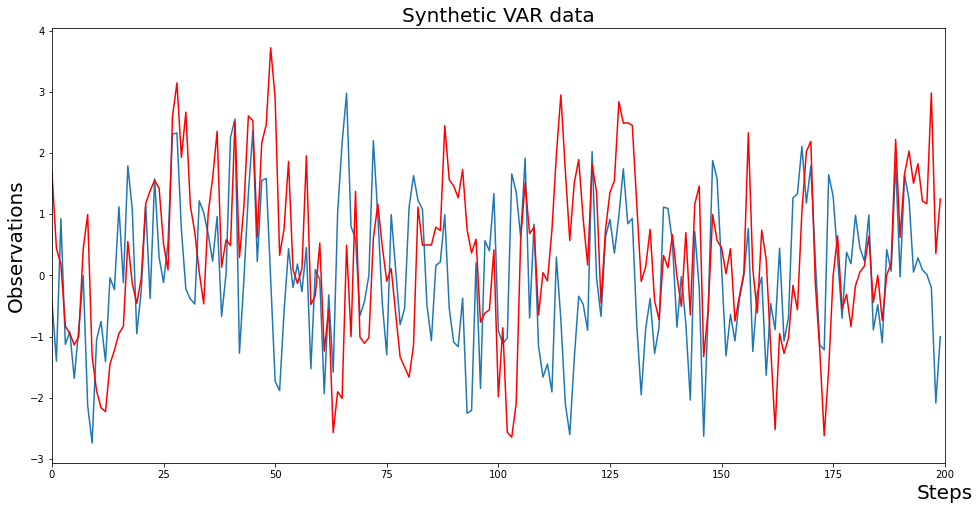

In [2]:
# Pick some fixed parameters
N = 200                     # 200 observations per series
burn = 50                   # burn-in period for simulation
C = np.asmatrix([[0],[0]])  # zero mean
S = np.asmatrix([[1,0.5],   # Variance/covariance of innovations
                 [0.5,1]])

# Generate sobol samples for parameter space
numSamples = 40            # we draw only 50 damples from the parameter space
parameterRange = np.array([
        (-0.5, 0.5),       # a1 param
        (-0.5, 0.5)])      # a2 param
samples = getSobolSamples(numSamples, parameterRange, skips = 500)

# Generate training data from samples
numParams = 2
xTrain = np.zeros([N,numParams,numSamples])
for i, sample in enumerate(samples):
    A = np.asmatrix([[0.6,sample[0]],
                     [sample[1],0.6]])
    VARsimTrain = VAR(C,A,S)
    xTrain[:,:,i] = VARsimTrain.simulate(N,burn).transpose()

# Generate 'empirical' series
trueParams = np.asarray([-0.25,0.15])
A = np.asmatrix([[0.6,trueParams[0]],
                 [trueParams[1],0.6]])

VARsim = VAR(C,A,S)
xEmp = VARsim.simulate(N,burn)
Lemp = VARsim.likelihood(xEmp)

# Plot the data
fig = plt.figure(figsize=(16,8))
fig.set_facecolor('white')
ax = plt.axes()
ax.plot(np.arange(N), xEmp[0,:])
ax.plot(np.arange(N), xEmp[1,:], color = 'r')
ax.set_xlim(0,N)
ax.set_xlabel(r'Steps', fontdict = {'fontsize': 20},position=(1, 0))
ax.set_ylabel(r'Observations', fontdict = {'fontsize': 20},position=(0, 0.5))
ax.set_title('Synthetic VAR data', fontdict = {'fontsize': 20});

Now, let's train the BEGRS surrogate. The only thing that the user needs to set is the following hyper parameters:
- The **number of latent variables** to use to model the actual observable variables.. Smaller is computationally better, larger produces a more flexible model. Here the model is small enough that we can use 2 latent variables, but in general, I recommend running a PCA analysis of the empirical data to find out the smallest number of factors that can adequately summarise the data.
- The **number of inducing points**. The Variational GP underpinning the BEGRS surrogate works on the assumption that the training data is *sparse*, in that it can be summarised by a smaller number of more informative points. This parameter selects the cap on the number of these inducing points. Like the latent variables the trade-off is that a smaller number is computationally cheaper, a larger number is more flexible, *but only up to a point*. 
- The **number of iterations** - self explanatory, it's the number of training iterations. This is usually set by trial and error, as in 'keep increasing the iterations until you see that the objective function no longer improves'...
- The **batch size** is the number of observations of training data processed at each step (BEGRS uses stochastic optimisation). All the training data is processed in each iteration, but this is broken up into random batches that are processed sequentially. In our case, the batch size is set so that all the data is process in one go (we only have 8000 training observations)
- The **learning rate** of the Adam optimiser used to update the parameters of the variational GP surrogate in between batches. Typically around 0.1, but this needs to be reduced for large training sets and set in line with the batch size (larger batch sizes allow for larger learning rates), otherwise the convergence of the surrogate risks happening before you've had the chance to process all the batches and thus see all the training data. 

Once these are set, we just pass the training data, parameter samples and parameter ranges to the object and start training.

In [3]:
# Set the hyper parameters
num_latents = 2         # We can set 2, small bivariate example
num_inducing_pts = 25   # Subset of 'non-sparse' inputs - 25 is enough!
numiter = 75            # Number of epoch iterations
batchSize = 10000       # Size of training minibatches - Can do all here
learning_rate = 0.1     # Learning rate (0.1 is good here)

# Create a begrs estimation object, train the surrogate on simulated data
t_start = time.time()
begrsEst = begrs()
begrsEst.setTrainingData(xTrain, samples, parameterRange)
begrsEst.train(num_latents, num_inducing_pts, batchSize, numiter, 
                learning_rate)
print(' Training time: {:10.4f} secs.'.format(time.time() - t_start))

───────────────────────────────────────────────────────────────────────────
 Setting training data set - Done
 - Normalised variables (0 mean, 1 std. dev.)

 N° of parameters:     2
 N° of variables:     2
 N° of parameter samples:    40
───────────────────────────────────────────────────────────────────────────
 Training gaussian surrogate model
 CUDA not available - Using CPU
Iteration 65 : 100%|█████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it, loss=0.443]


Iteration 75 : 100%|█████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it, loss=0.405]
 Training time:   214.1803 secs.


That did not take too long, after all we only have 8000 observations and 25 inducing points, so he matrices that need to be manipulated are relatively small.

Now that the surrogate is trained, let's see if we can recover the parameters of the synthetic 'empirical' data. Because we have a simple VAR with known likelihood function, we'll also run a maximum likelihood estimation to compare.

As stated above, we need to combine the surrogate likelihood with a prior in order to build a  posterior to maximise. This can be done as illustrated in the `logP` function below.

As explained already, BEGRS provides a minimal prior that restricts the parameters to within the bounds from which the training data was drawn. This prior is a continuous relaxation of the uniform distribution, so it is virtually flat with the bounds, but continuous across the bounds. This prior should *always* be included to ensure that Bayesian estimation stays confined in the parameter bounds, with the understanding that the user can augment the prior with functions of their choice.

We are also going to take advantage of the fact that BEGRS returns not only the surrogate likelihood for a given set of parameters, but also the gradient of the likelihood for those values. This enables us to use BFGS with the 'jacobian' option activated, which produces much faster convergence because it removes the need for the repeated calls to the objective function that are required when using finite differences. Note that this implies that should a user choose to add their own prior, they will also need to supply the gradient of the lo prior for the method to work.

In [4]:
# First, we need to declare the log posterior to be optimised:
def logP(sample):
    # Example of posterior function, using the BEGRS soft flat prior
    # Any prior can be used, but needs to produce both the log prior and its
    # gradient.
    
    prior = begrsEst.softLogPrior(sample) 
    logL = begrsEst.logP(sample)

    return (prior[0] + logL[0], prior[1] + logL[1])

# Estimate the parameters from the empirical data
# Set testing data
begrsEst.setTestingData(xEmp.transpose())

# Find posterior mode
negLogLik = lambda *args: tuple( -i for i in logP(*args))
print('Finding MAP vector')
t_start = time.time()

init = np.zeros(numParams)
bounds = numParams*[(-3**0.5,3**0.5)]
sampleMAP = minimize(negLogLik, init, method='L-BFGS-B',
                      bounds = bounds, jac = True)
print('BEGRS maximisation time: {:10.4f} secs.'.format(time.time() - t_start))
mapEst = begrsEst.uncenter(sampleMAP.x)

# Let's see what the maximum likelihood estimate is for comparison
negLogLikTrue = lambda vec:  -VARsim.likelihood(xEmp,
                                                A=np.asmatrix([[0.6,vec[0]],
                                                               [vec[1],0.6]]
                                                              )
                                                )
print('Finding Maximum likelihood vector')
t_start = time.time()
maximumLikelihoodVAR = minimize(negLogLikTrue, 
                          init,
                          method='BFGS', 
                          options={'disp':True,
                                   'gtol':1e-4})
print('Max. Likelihood time: {:10.4f} secs.'.format(time.time() - t_start))

# Show tables to compare performance
# Gather parameter values 
parameterValues = np.concatenate(
                            (trueParams[None,:],
                             mapEst[None,:],
                             maximumLikelihoodVAR.x[None,:]),
                                  axis=0)
# Print table
table = SimpleTable(
        formatTableText(parameterValues,'{:8.3f}'),
        stubs=['True','BEGRS', 'MLE'],
        headers=['param 1','param 2'],
        title='Estimation performance',
    )

print(table)
print('\n')

───────────────────────────────────────────────────────────────────────────
 Setting testing data set - Done
 Precomputing Likelihood components - Done
Finding MAP vector
BEGRS maximisation time:     0.3701 secs.
Finding Maximum likelihood vector
Optimization terminated successfully.
         Current function value: 353.242523
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Max. Likelihood time:     0.1157 secs.
 Estimation performance
      param 1  param 2 
-----------------------
True    -0.250    0.150
BEGRS   -0.253    0.141
MLE     -0.191    0.152
-----------------------




The comparison of parameter estimates shows that the BEGRS is actually not too bad at all, especially considering the 'relatively' small number of training series (40 draws from the parameter space, 200 observations each)!

To really illustrate what the surrogate is doing, let's do a quick grid evaluation to visualise the surrogate likelihood surface compared to the real likelihood. Luckily, because the surrogate is very small, this doesn't take much time (unlike the NPSMLE/SMM example).

 Getting surrogate likelihood surface in sample space
 Row  1 time:     0.6924 secs.
 Row  2 time:     0.7288 secs.
 Row  3 time:     0.6934 secs.
 Row  4 time:     0.6795 secs.
 Row  5 time:     0.7187 secs.
 Row  6 time:     0.7072 secs.
 Row  7 time:     0.7468 secs.
 Row  8 time:     0.7271 secs.
 Row  9 time:     0.7843 secs.
 Row 10 time:     0.7238 secs.
 Row 11 time:     0.6818 secs.
 Row 12 time:     0.6722 secs.
 Row 13 time:     0.7267 secs.
 Row 14 time:     0.8383 secs.
 Row 15 time:     0.8336 secs.
 Row 16 time:     0.8355 secs.
 Row 17 time:     0.8572 secs.
 Row 18 time:     0.8417 secs.
 Row 19 time:     0.7127 secs.
 Row 20 time:     0.7542 secs.
 Row 21 time:     0.7580 secs.
 Row 22 time:     0.7116 secs.
 Row 23 time:     0.7204 secs.
 Row 24 time:     0.6849 secs.
 Row 25 time:     0.7940 secs.
 Row 26 time:     0.7003 secs.
 Row 27 time:     0.7393 secs.
 Row 28 time:     0.7358 secs.
 Row 29 time:     0.6928 secs.
 Row 30 time:     0.8243 secs.
 Row 31 time:   

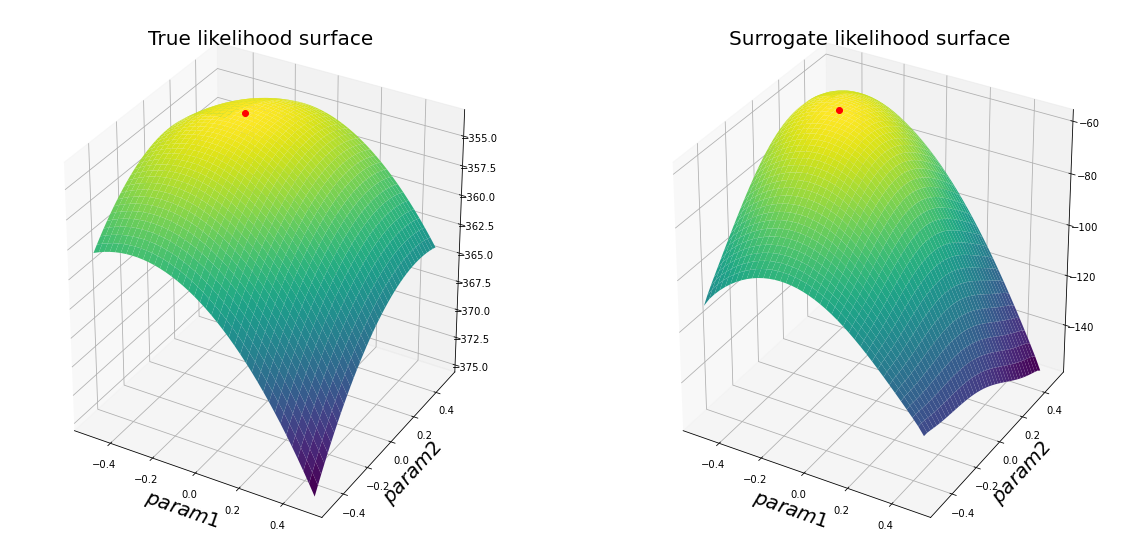

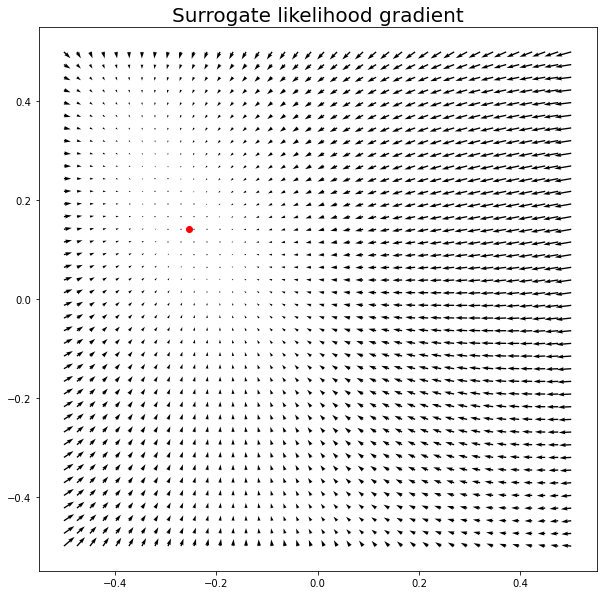

In [5]:
# Generate Likelihood surfaces for visualisation
res = 40
paramBase = np.linspace(-0.5,0.5,res)
theta1, theta2 = np.meshgrid(paramBase, paramBase)
logLikSurf = np.zeros([res,res])
logLikSurfGP = np.zeros([res,res])
dTheta_1 = np.zeros([res,res])
dTheta_2 = np.zeros([res,res])

print(' Getting surrogate likelihood surface in sample space')
t_total = time.time()
for i in range(res):
    t_start = time.time()

    for j in range(res):

        theta = begrsEst.center(        # Don't forget to center!!
                            np.asarray(
                                [theta1[i,j], theta2[i,j]]
                                    )
                                )
        
        logLikInfo = logP(theta)
        logLikSurfGP[i,j] = logLikInfo[0]
        dTheta_1[i,j] = logLikInfo[1][0]
        dTheta_2[i,j] = logLikInfo[1][1]
    print(' Row {:2d} time: {:10.4f} secs.'.format(i+1,time.time() - t_start))

print(' Likelihood GP surf:    {:10.4f} secs.'.format(time.time() - t_total))

print('\n Getting true likelihood surface in sample space')
t_total = time.time()
for i in range(res):
    t_start = time.time()
    for j in range(res):
        A = np.asmatrix([[0.6,theta1[i,j]],
                     [theta2[i,j],0.6]])
        VARsimSurf = VAR(C,A,S)
        logLikSurf[i,j] = VARsimSurf.likelihood(xEmp)
    print(' Row {:2d} time: {:10.4f} secs.'.format(i+1,time.time() - t_start))

print(' Likelihood true surf: {:10.4f} secs.'.format(time.time() - t_total))

# Plot surfaces
fig = plt.figure(figsize=(20,10))
fig.set_facecolor("white")
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(theta1, theta2, logLikSurf, cmap='viridis')
ax.plot3D([maximumLikelihoodVAR.x[0]], [maximumLikelihoodVAR.x[1]], 
          [-maximumLikelihoodVAR.fun], marker = 'o', color = 'r', zorder = 5)
ax.set_xlabel(r'$param 1$', fontdict = {'fontsize': 20},position=(1, 0))
ax.set_ylabel(r'$param 2$', fontdict = {'fontsize': 20},position=(0, 1))
ax.set_title('True likelihood surface', fontdict = {'fontsize': 20});
    

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(theta1, theta2, logLikSurfGP, cmap='viridis')
ax.plot3D([mapEst[0]], [mapEst[1]], [-sampleMAP.fun], 
              marker = 'o', color = 'r', zorder = 5)
ax.set_xlabel(r'$param 1$', fontdict = {'fontsize': 20},position=(1, 0))
ax.set_ylabel(r'$param 2$', fontdict = {'fontsize': 20},position=(0, 1))
ax.set_title('Surrogate likelihood surface', fontdict = {'fontsize': 20});

fig = plt.figure(figsize=(10,10))
fig.set_facecolor("white")
ax = fig.add_subplot(1, 1, 1)
ax.quiver(theta1, theta2, dTheta_1, dTheta_2)
ax.plot(mapEst[0], mapEst[1], marker = 'o', color = 'r')
ax.set_title('Surrogate likelihood gradient', fontdict = {'fontsize': 20});

These visualisations are useful in illustrating several key points:
- First, the surrogate likelihood surface is clearly only an *approximation* of the true surface. It is easy to spot the difference with the true likelihood surface at first glance.
- Second, the surrogate likelihood nevertheless captures the essential response figures of the true likelihood surface.
- Finally, as is visible in the quiver plot, each time the surrogate likelihood is calculated for a point in the parameter set, BEGRS provides the gradient at that point 'for free' (not quite, but the extra cost is negligible). 

The availability of the gradient is extremely useful in improving optimisation performance. We have already discussed above how this allows the use of user-provided gradients in BFGS, but this also allows the use of Hamiltonian Monte Carlo (HMC), which is much more efficient than traditional MCMC methods (such as Metropolis-Hastings) and requires far fewer samples from the parameter space to obtain a reliable estimate of the posterior distribution.

OK, so let's go Bayesian, to illustrate this. Given that the methodology is designed to be Bayesian, I kind of need to show it! As already stated at the start, the specific version of HMC implemented is the 'No U-Turn Sampler' (NUTS).

 NUTS estimation on Synthetic data
Progress: [##############################] 5100 of 5100 samples
 HMC time:     4.0550 mins.


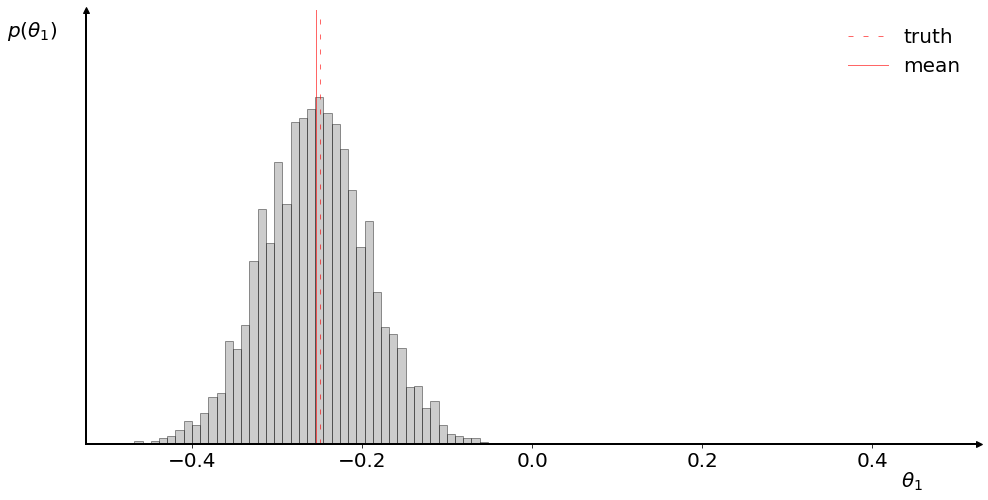

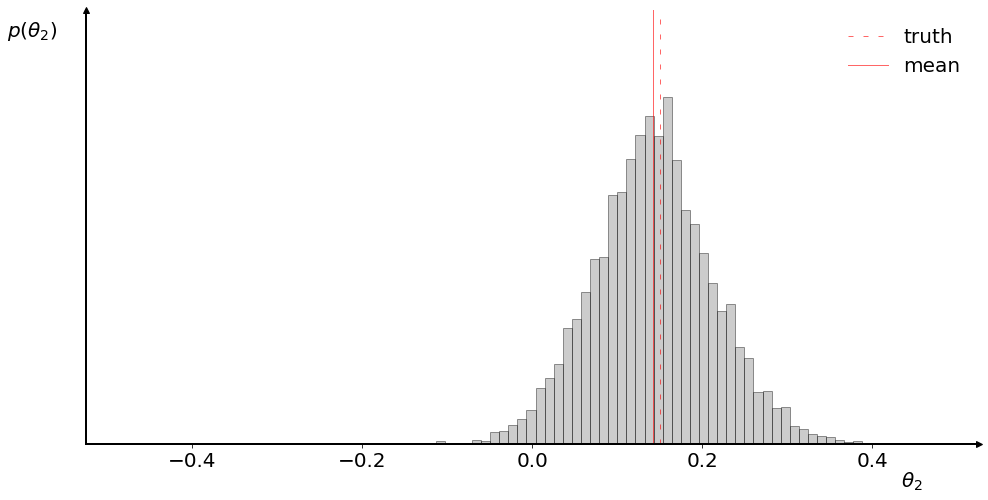

In [6]:
# Let's go full Bayesian. After all, it's 'BEGRS', not 'MLEGRS'...
print(' NUTS estimation on Synthetic data')
start = smp.state.State.fromfunc(logP)
start.update({'sample': sampleMAP.x})

scale = 1*np.ones([len(sampleMAP.x)])
E_cutoff = -2*logP(sampleMAP.x)[0]

nuts = smp.NUTS(logP, start, scale = {'sample': scale},
                grad_logp = True, 
                step_size = 0.01, 
                Emax = E_cutoff) 
chain = nuts.sample(5100, burn=100)     # 5000 samples should be enough
print(' HMC time: {:10.4f} mins.'.format((time.time() - t_start)/60))

# Uncenter the samples
flat_samples = np.zeros_like(chain.sample)
for i, sampleCntrd in enumerate(chain.sample):
    flat_samples[i,:] = begrsEst.uncenter(sampleCntrd)

# Get expected values
theta_mean = np.mean(flat_samples, axis = 0)

# Generate plots - most of this is just 'prettifying code' to make a nice plot
fontSize = 20
for i in range(2):
    d = flat_samples[:,i]    
    x_range = parameterRange[i,1] - parameterRange[i,0]
    xlim_left = parameterRange[i,0] - x_range*0.025
    xlim_right = parameterRange[i,1] + x_range*0.025
    
    fig = plt.figure(figsize=(16,8))
    fig.set_facecolor('white')
    ax = plt.axes()
    posteriorDist = ax.hist(x=d, bins='fd', density = True, edgecolor = 'black', 
                  color = 'gray', alpha=0.4)
    y_max = 1.25*max(posteriorDist[0])
    ax.plot([trueParams[i],trueParams[i]], [0, y_max], linestyle = (0, (5, 10)), 
            linewidth=1, color = 'r', alpha=0.6, 
            label = 'truth')
    ax.plot([theta_mean[i],theta_mean[i]], [0, y_max], 'r',  linewidth=1, 
            alpha=0.6, label = 'mean')
    ax.set_xlabel(r'$\theta_{:d}$'.format(i+1), 
                  fontdict = {'fontsize': fontSize})
    ax.set_ylabel(r'$p(\theta_{:d})$'.format(i+1), rotation=0, labelpad=100,
                  fontdict = {'fontsize': fontSize})
    ax.xaxis.set_label_coords(.925, -.06)
    ax.yaxis.set_label_coords(-.06, .925)
    ax.axes.yaxis.set_ticks([])
    ax.legend(loc='best', frameon=False, prop={'size':fontSize})

    ax.set_ylim(top = y_max, bottom = 0)
    ax.set_xlim(left = xlim_left,right = xlim_right)
    ax.plot(xlim_right, 0, ">k", clip_on=False)
    ax.plot(xlim_left, y_max, "^k", clip_on=False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='x', labelsize=fontSize)    
    ax.tick_params(axis='y', labelsize=fontSize)

The key benefit of HMC/NUTS is that 5000 samples is enough to generate a reliable posterior. Metropolis-Hastings would barely have warmed up on that budget... Note that the reason we can complete this in 'only' 4 minutes is the extremely small nature of the toy model we are examining.

So now we need to move on to a more challenging version of the model, which will scale the problem up to something that we are more familiar with in our research.